# CAM, Grad-CAM implementation

### 1. 데이터셋 준비

In [5]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', split=['train', 'test'], shuffle_files=True, with_info=True)

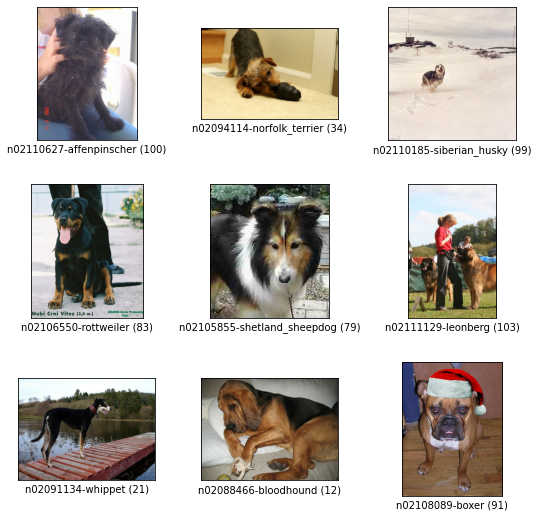

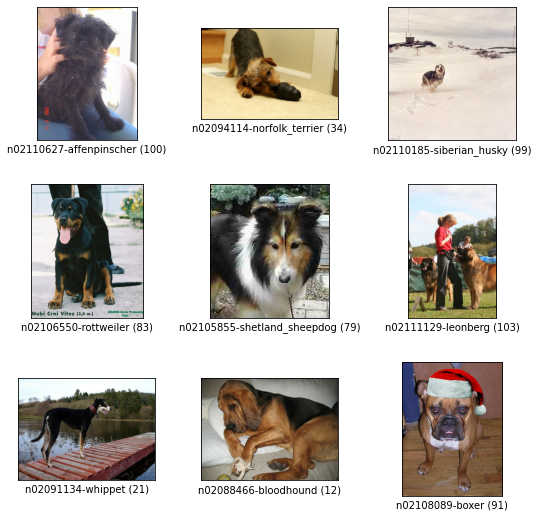

In [8]:
tfds.show_examples(ds_train, ds_info)

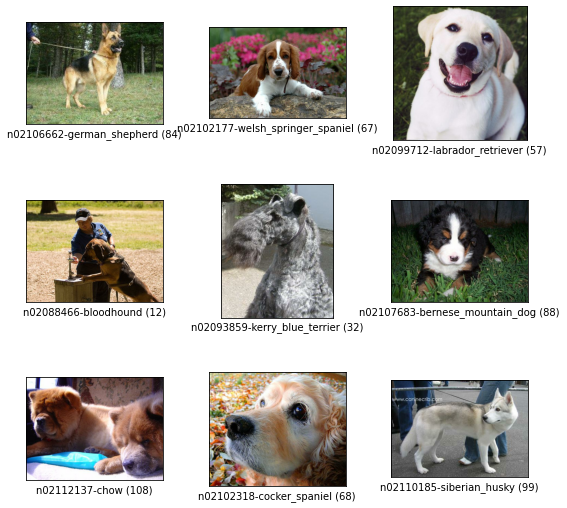

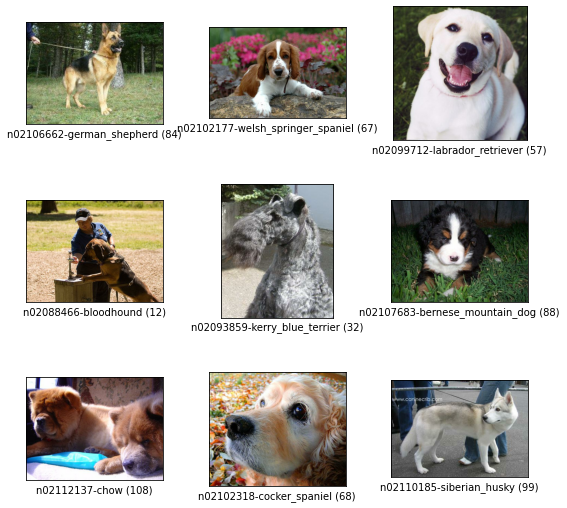

In [12]:
tfds.show_examples(ds_test, ds_info)

### 2. 물체의 위치정보

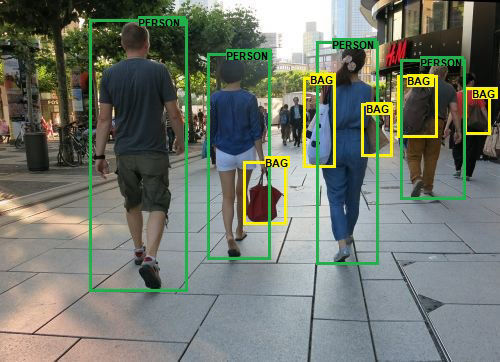

In [13]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

- bbox는 위 그림과 같이 물체의 위치를 사각형 영역으로 표기하는 방법이다. BBoxFeature 타입으로 정의된 것을 확인할 수 있다.

### 3. CAM을 위한 모델 만들기

미리 데이터에 훈련된 ResNet50을 기반으로 그 뒤에 필요한 레이어를 붙여 CAM을 구현한다.

In [16]:
num_classes = ds_info.features['label'].num_classes
base_model = keras.applications.resnet50.ResNet50(include_top = False,  # Fully connected layer 대신 GAP 연산을 사용하므로 제거
                                                 weights = 'imagenet',
                                                 input_shape = (224,224,3),
                                                 pooling = 'avg'  # GAP 적용
                                                 )

x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model = keras.Model(inputs = base_model.input, outputs = preds)

In [18]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

- 마지막에 softmax 전에 GAP가 들어간 것을 확인할 수 있다.
   
   
- conv5_block3_out의 output이 feature map이 된다. 따라서 이 feature map에 GAP을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행한다.

### 4. CAM 모델 학습

In [19]:
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224,224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [20]:
# 데이터셋에 전처리, 배치처리 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [21]:
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)    #batch_size = 16으로 정의해둔 것을 잊지말자.

(16, 224, 224, 3)
(16,)


In [22]:
tf.random.set_seed(2021)
cam_model.compile(loss='sparse_categorical_crossentropy',
                 optimizer = tf.keras.optimizers.SGD(lr=0.01),
                 metrics=['accuracy'])

In [25]:
history_cam_model = cam_model.fit(ds_train_norm,
                                 steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
                                 validation_steps = int(ds_info.splits['test'].num_examples/16),
                                 epochs = 15,
                                 validation_data = ds_test_norm,
                                 verbose = 1,
                                 use_multiprocessing = True
                                 )

Epoch 1/15
750/750 [==============================] - 378s 457ms/step - loss: 3.1464 - accuracy: 0.2842 - val_loss: 3.1162 - val_accuracy: 0.2460
Epoch 2/15
750/750 [==============================] - 326s 435ms/step - loss: 0.9126 - accuracy: 0.7430 - val_loss: 1.1176 - val_accuracy: 0.6742
Epoch 3/15
750/750 [==============================] - 327s 436ms/step - loss: 0.3503 - accuracy: 0.9133 - val_loss: 0.9432 - val_accuracy: 0.7266
Epoch 4/15
750/750 [==============================] - 327s 436ms/step - loss: 0.0989 - accuracy: 0.9861 - val_loss: 0.8877 - val_accuracy: 0.7403
Epoch 5/15
750/750 [==============================] - 327s 436ms/step - loss: 0.0304 - accuracy: 0.9988 - val_loss: 0.9199 - val_accuracy: 0.7402
Epoch 6/15
750/750 [==============================] - 329s 439ms/step - loss: 0.0178 - accuracy: 0.9994 - val_loss: 0.9171 - val_accuracy: 0.7425
Epoch 7/15
750/750 [==============================] - 325s 434ms/step - loss: 0.0131 - accuracy: 0.9998 - val_loss: 0.9330 -

# CAM

In [26]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/Going_Deeper/3.class activation map/cam_model.h5'
cam_model.save(cam_model_path)

In [1]:
# 메모리 부족 대비 이전 스텝의 코드를 모아서 실행

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

- CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에 get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 한다.

In [2]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

116


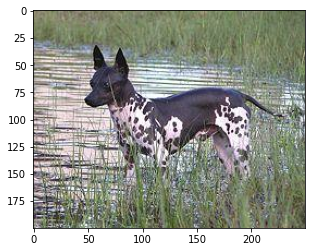

In [3]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [4]:
# 이전에 학습한 모델 불러오기

import os

cam_model_path = os.getenv('HOME')+'/aiffel/Going_Deeper/3.class activation map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

CAM 생성을 위해서는 특성 맵, 클래스별 확률을 얻기 위한 sofmax layer의 weight, 원하는 클래스의 출력 값이 필요하다. 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 한다.

In [5]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해준다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    # -1 = softmax, -2 = GAP, -3 = Conv
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

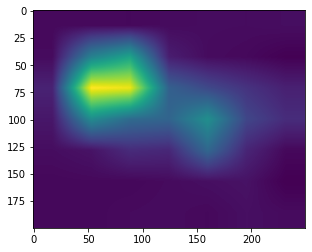

In [6]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

이렇게 그려진 CAM 이미지를 원본 이미지와 합친다.

In [7]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

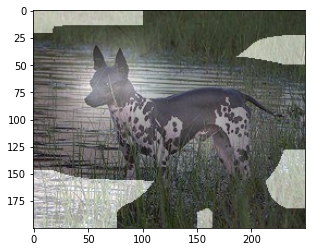

In [8]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# Grad-CAM

- Grad-CAM을 이용해서 CAM 만들기

100


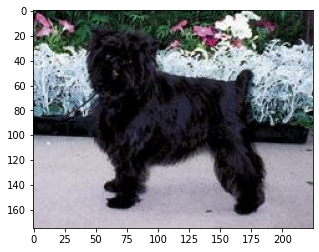

In [9]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

Grad-CAM은 CAM과 달리 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, Gradient 계산을 원하는 관찰 대상 레이어 activation layer를 뽑아서 쓸 수 있도록 activation layer의 이름을 받고 이를 활용해야 한다.

In [10]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    #Grad-CAM에서도 CAM과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의한다.
    #but Grad-CAM은 원하는 레이어가 다를 수 있으므로 해당 레이어의 이름으로 찾은 후 output으로 추가한다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    #Gradient를 얻기 위해 tape 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        
        loss = pred[: , class_idx] #원하는 클래스의 예측값 얻기
        output = conv_output[0] # 원하는 layer의 output을 얻는다
        grad_val = tape.gradient(loss, conv_output)[0]  #예측값에 따른 layer의 gradient를 얻는다.
        
    weights = np.mean(grad_val, axis = (0, 1))
    grad_cam_image = np.zeros(dtype = np.float32, shape = conv_output.shape[0:2])
    for k, w in enumerate(weights):
        #각 클래스별 weight와 해장 layer의 output을 곱해 class activation map을 얻는다.
        grad_cam_image += w*output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

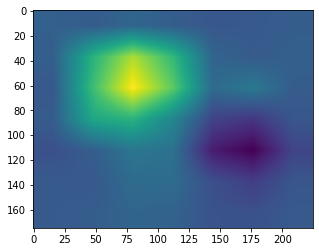

In [11]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

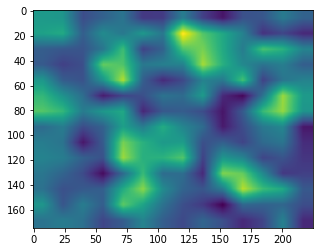

In [12]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

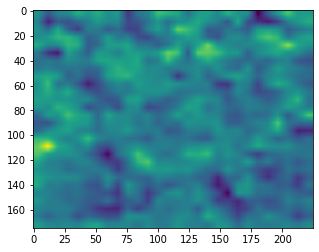

In [13]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

# Detection with CAM

116


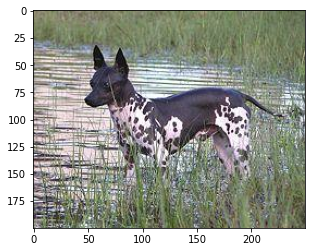

In [14]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

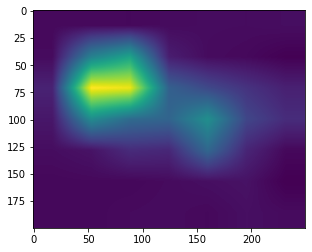

In [15]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [16]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [17]:
rect = get_bbox(cam_image)
rect

array([[-13, 107],
       [ 23,  -8],
       [262,  68],
       [225, 184]])

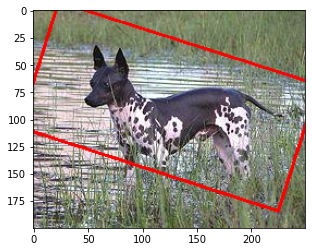

In [25]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (255,0,0), 2)
plt.imshow(image)
plt.show()

### IoU (Intersection Over Union)

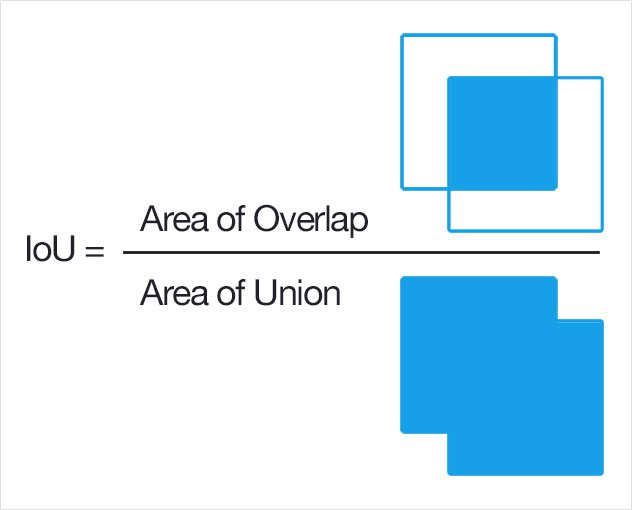

In [19]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [20]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.04, -0.052, 0.92, 1.048]

In [21]:
item['objects']['bbox']

array([[0.165, 0.192, 0.8  , 0.924]], dtype=float32)

In [23]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [24]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.4401704522244857